In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './..')
sys.path.insert(0, './../scripts')

In [2]:
from importlib import reload

import pickle
import time

import numpy as np
from scipy import interpolate
from scipy import linalg
from scipy import optimize
from scipy import sparse
from scipy.special import ive

import matplotlib.pyplot as plt

import plot_func as pf
# import util_func as uf
import analyze_func as af

# Define functions to simulate dynamics

In [13]:
from scipy.integrate import solve_ivp

# N4 = 80
N4 = 60

def fio_rect(x):
#     x[x<0] = 0
#     return x
    return np.fmax(x,0)

def dynamics_system(y,inp_ff,Wrec,\
                    gamma_rec,gamma_ff,N,tau):
#     argE = gamma_rec * np.dot(Wrec[:N],y) + gamma_ff * inp_ff[0]
#     argI = gamma_rec * np.dot(Wrec[N:],y) + gamma_ff * inp_ff[1]
#     return 1./tau*( -y + fio_rect(np.concatenate([argE,argI])))
    arg = gamma_rec * np.dot(Wrec,y) + gamma_ff * inp_ff.flatten()
    return 1./tau*( -y + fio_rect(arg))

def integrate(y0,inp,dt,Nt,Wrec,gamma_rec=1.02):
    y = y0
    for t_idx in range(Nt):
        out = dynamics_system(y,inp,Wrec,gamma_rec,1.0,N4*N4,1.0)
        dy = out
        y = y + dt*dy
    if len(y)==N4**2:
        return y
    else:
        return np.array([y[:N4**2].reshape((N4,N4)),y[N4**2:].reshape((N4,N4))])
#     def ode_fun(t,y):
#         return dynamics_system(y,inp,W4to4,gamma_rec,1.0,N4*N4,1.0)
#     sol = solve_ivp(ode_fun,[0,dt*Nt],y0,method='RK23',first_step=dt)
#     return np.array([sol.y[:N4**2,-1].reshape((N4,N4)),sol.y[N4**2:,-1].reshape((N4,N4))])

# Build L4 Input Map

In [7]:
from scipy.stats import qmc

xs,ys = np.meshgrid(np.arange(80)/80,np.arange(80)/80)
dxs = np.abs(xs[:,:,None,None] - xs[None,None,:,:])
dxs[dxs > 0.5] = 1 - dxs[dxs > 0.5]
dys = np.abs(ys[:,:,None,None] - ys[None,None,:,:])
dys[dys > 0.5] = 1 - dys[dys > 0.5]
dists = dxs**2 + dys**2

def gen_maps(N,dens,bgnd_min,bgnd_max,maxOS,meanOS,seed=0,bgnd_scale=4,areaCV=0,bgnd_pow=1,
             cont_oris=False,cont_sels=False):
    rng = np.random.default_rng(seed)
    
    bgndOS = (bgnd_min+bgnd_pow*bgnd_max)/(bgnd_pow+1)

    nclstr = np.round(N**2*dens).astype(int)
    sig2 = (meanOS - bgndOS)/((maxOS - bgndOS)*dens*np.pi) / N**2

    rng = np.random.default_rng(seed)

    clstr_pts = qmc.Halton(d=2,scramble=False,seed=seed).random(nclstr)
    
    oris = 2*np.pi*rng.random(nclstr)
    
    if np.isclose(areaCV,0):
        sig2s = sig2*np.ones(nclstr)
        rng.gamma(shape=1,scale=1,size=nclstr)
    else:
        shape = 1/areaCV**2
        scale = sig2/shape
        sig2s = rng.gamma(shape=shape,scale=scale,size=nclstr)
    
    xs,ys = np.meshgrid(np.arange(N)/N,np.arange(N)/N)
    dxs = np.abs(xs[None,:,:] - clstr_pts[:,0,None,None])
    dxs[dxs > 0.5] = 1 - dxs[dxs > 0.5]
    dys = np.abs(ys[None,:,:] - clstr_pts[:,1,None,None])
    dys[dys > 0.5] = 1 - dys[dys > 0.5]
    ds2s = dxs**2 + dys**2

    omap = np.zeros((N,N),dtype='complex64')
    holes = np.zeros((N,N),dtype='float64')
    
    for i in range(nclstr):
        omap += np.heaviside(1.01*sig2s[i]-ds2s[i],1)*np.exp(1j*oris[i])
        holes += np.heaviside(1.01*sig2s[i]-ds2s[i],1)
            
    true_clstr_size = np.sum(np.abs(omap))
    omap *= maxOS*nclstr*np.pi*sig2*N**2/true_clstr_size

    ks = np.arange(N)/N
    ks[ks > 0.5] = ks[ks > 0.5] - 1
    kxs,kys = np.meshgrid(ks*N,ks*N)

    bgnd_ofield = np.fft.ifft2(np.exp(-0.5*(kxs**2+kys**2)*sig2*bgnd_scale**2)*\
        np.fft.fft2(np.exp(1j*2*np.pi*rng.random((N,N)))))
    bgnd_ofield /= np.abs(bgnd_ofield)
    # bgnd_sfield = np.real(np.fft.ifft2(np.exp(-0.5*(kxs**2+kys**2)*sig2*bgnd_scale**2)*np.fft.fft2(rng.random((N,N)))))
    # bgnd_sfield -= np.min(bgnd_sfield)
    # bgnd_sfield = bgnd_sfield**bgnd_pow
    # bgnd_sfield *= (bgnd_max-bgnd_min) / (np.max(bgnd_sfield) - np.min(bgnd_sfield))
    # bgnd_sfield += bgnd_min
    # bgnd_sfield /= nclstr*np.pi*sig2*N**2/true_clstr_size
    bgnd_sfield = bgnd_min+(bgnd_max-bgnd_min)*rng.random((N,N))**bgnd_pow
    if cont_sels:
        min_clstr_dists = np.min(ds2s,0)
        min_dist = np.min(min_clstr_dists[holes==0])
        max_dist = np.max(min_clstr_dists[holes==0])
        min_clstr_dists[holes==1] = min_dist + (max_dist-min_dist)*rng.random(np.count_nonzero(holes))
        bgnd_sfield = bgnd_sfield.flatten()
        bgnd_sfield[np.argsort(min_clstr_dists.flatten())[::-1]] = np.sort(bgnd_sfield).flatten()
        bgnd_sfield = bgnd_sfield.reshape(N,N)
    if cont_oris:
        omap = (bgnd_sfield*(1-holes)+maxOS*nclstr*np.pi*sig2*N**2/true_clstr_size*holes)*bgnd_ofield
    else:
        omap += bgnd_sfield*bgnd_ofield*(1-holes)
    
    return omap

In [8]:
dens = 0.01
bgnd_min = 0.00
bgnd_max = 0.3
meanOS = 0.18
maxOS = 0.6

omap = gen_maps(80,dens,bgnd_min,bgnd_max,maxOS,meanOS,0,bgnd_scale=6)
cont_omap = gen_maps(80,dens,bgnd_min,bgnd_max,maxOS,meanOS,0,bgnd_scale=6,cont_oris=True,cont_sels=True)
sig2 = (meanOS - 0.5*(bgnd_min+bgnd_max))/((maxOS - 0.5*(bgnd_min+bgnd_max))*dens*np.pi) / 80**2

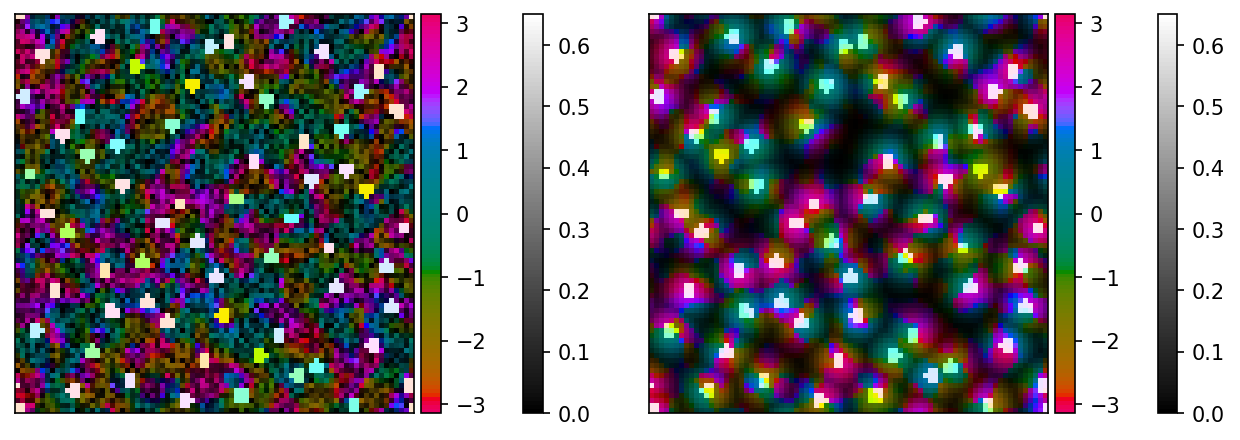

In [183]:
fig,axs = plt.subplots(1,2,figsize=(10,4),dpi=150)
pf.domcolbar(fig,axs[0],omap,rlim=(0,0.65),origin='lower')
pf.domcolbar(fig,axs[1],cont_omap,rlim=(0,0.65),origin='lower')

# Model inputs as single elongated rubregion driven by grating

In [9]:
oris = np.linspace(0,np.pi,100,endpoint=False) - np.pi/2
phss = np.linspace(0,2*np.pi,100,endpoint=False) - np.pi

def elong_inp(ksig,ori,phs,thr=0):
    return np.fmax(0,np.cos(phs)*np.exp(-(ksig*np.sin(ori))**2/2) - thr) / (ive(0,ksig**2/4)) * np.pi

def elong_os(ksig):
    return ive(1,ksig**2/4) / ive(0,ksig**2/4)

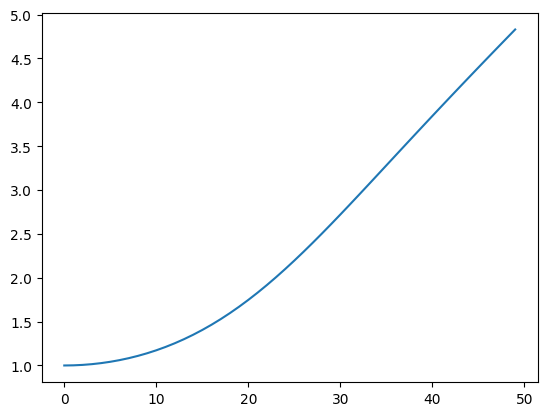

In [65]:
plt.plot(1/ive(0,np.linspace(0,4)**2/4))

In [10]:
ksigs = np.linspace(0,2.5,251)
oss = elong_os(ksigs)

ksig_os_itp = interpolate.interp1d(oss,ksigs,fill_value='extrapolate')

del ksigs,oss

In [19]:
ksmap = ksig_os_itp(np.abs(omap))
cont_ksmap = ksig_os_itp(np.abs(cont_omap))
pos = np.angle(omap)/2
cont_pos = np.angle(cont_omap)/2

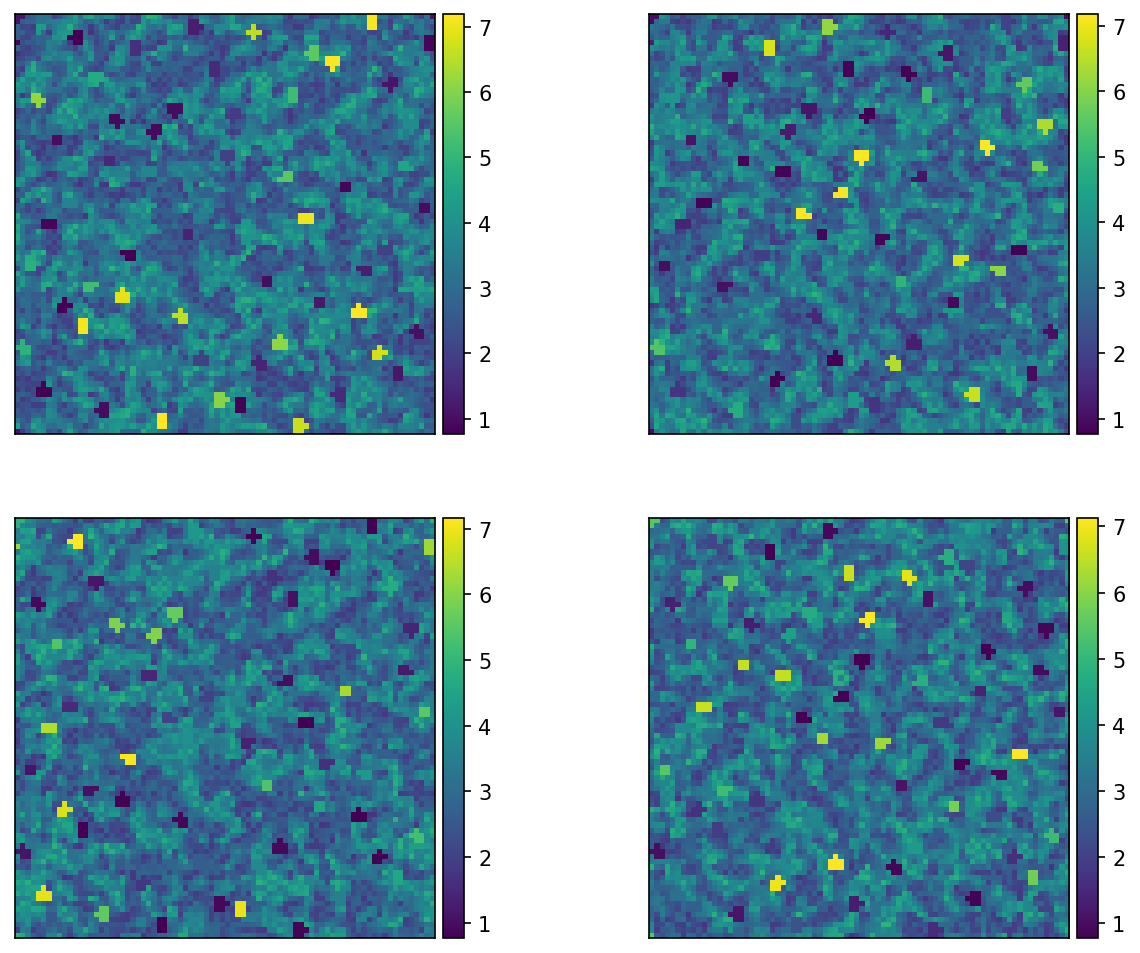

In [51]:
fig,axs = plt.subplots(2,2,figsize=(10,8),dpi=150)

pf.imshowbar(fig,axs[0,0],elong_inp(ksmap,pos,0),cmap='viridis')
pf.imshowbar(fig,axs[0,1],elong_inp(ksmap,pos-np.pi/4,0),cmap='viridis')
pf.imshowbar(fig,axs[1,0],elong_inp(ksmap,pos-np.pi/2,0),cmap='viridis')
pf.imshowbar(fig,axs[1,1],elong_inp(ksmap,pos-3*np.pi/4,0),cmap='viridis')

# Create phase scattered phase map

In [17]:
rf_sct_scale = 3
L_mm = N4/11
mag_fact = 0.02
L_deg = L_mm / np.sqrt(mag_fact)
grate_freq = 0.06

print(np.sqrt(sig2)*rf_sct_scale*L_deg)

def gen_rf_sct_map(N,sig2,sct_scale,seed=0):
    rng = np.random.default_rng(seed)
    
    sctmap = rng.normal(loc=0,scale=np.sqrt(sig2)*sct_scale,size=(N,N,2))
    polmap = rng.binomial(n=1,p=0.5,size=(N,N))
    
    return sctmap,polmap

def gen_abs_phs_map(N,rf_sct_map,pol_map,ori,freq,Lgrid):
    xs,ys = np.meshgrid(np.arange(N)/N,np.arange(N)/N)
    abs_rf_centx = rf_sct_map[:,:,0] + xs
    abs_rf_centy = rf_sct_map[:,:,1] + ys
    
    abs_phs = 2*np.pi*np.mod(freq*Lgrid*(np.cos(ori)*abs_rf_centx + np.sin(ori)*abs_rf_centy) + 0.5*pol_map,1)
    return abs_phs

sctmap,polmap = gen_rf_sct_map(N4,sig2,rf_sct_scale)
abs_phs = gen_abs_phs_map(N4,sctmap,polmap,0,grate_freq,L_deg)

2.809266923805015


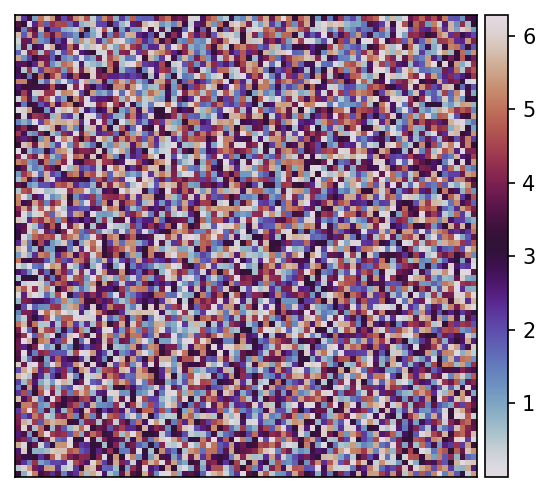

In [164]:
fig,ax = plt.subplots(1,1,figsize=(5,4),dpi=150)

pf.imshowbar(fig,ax,abs_phs,cmap='twilight',origin='lower')

# Simulate responses

In [186]:
n_oris = 4
n_phss = 8
n_inp = n_oris*n_phss
inp_oris = np.arange(n_oris)/n_oris * np.pi
inp_phss = np.arange(n_phss)/n_phss * 2*np.pi
inps = np.zeros((n_oris,n_phss,N4,N4))
cont_inps = np.zeros((n_oris,n_phss,N4,N4))

# ring_image = np.fft.fftshift(gen_gaussian_random_field.generate_ring(N4,N4,0,N4/4))

for ori_idx,ori in enumerate(inp_oris):
    abs_phs = gen_abs_phs_map(N4,sctmap,polmap,ori,grate_freq,L_deg)
    for phs_idx,phs in enumerate(inp_phss):
        inps[ori_idx,phs_idx] = elong_inp(ksmap,ori-pos,phs-abs_phs)
        cont_inps[ori_idx,phs_idx] = elong_inp(cont_ksmap,ori-cont_pos,phs-abs_phs)

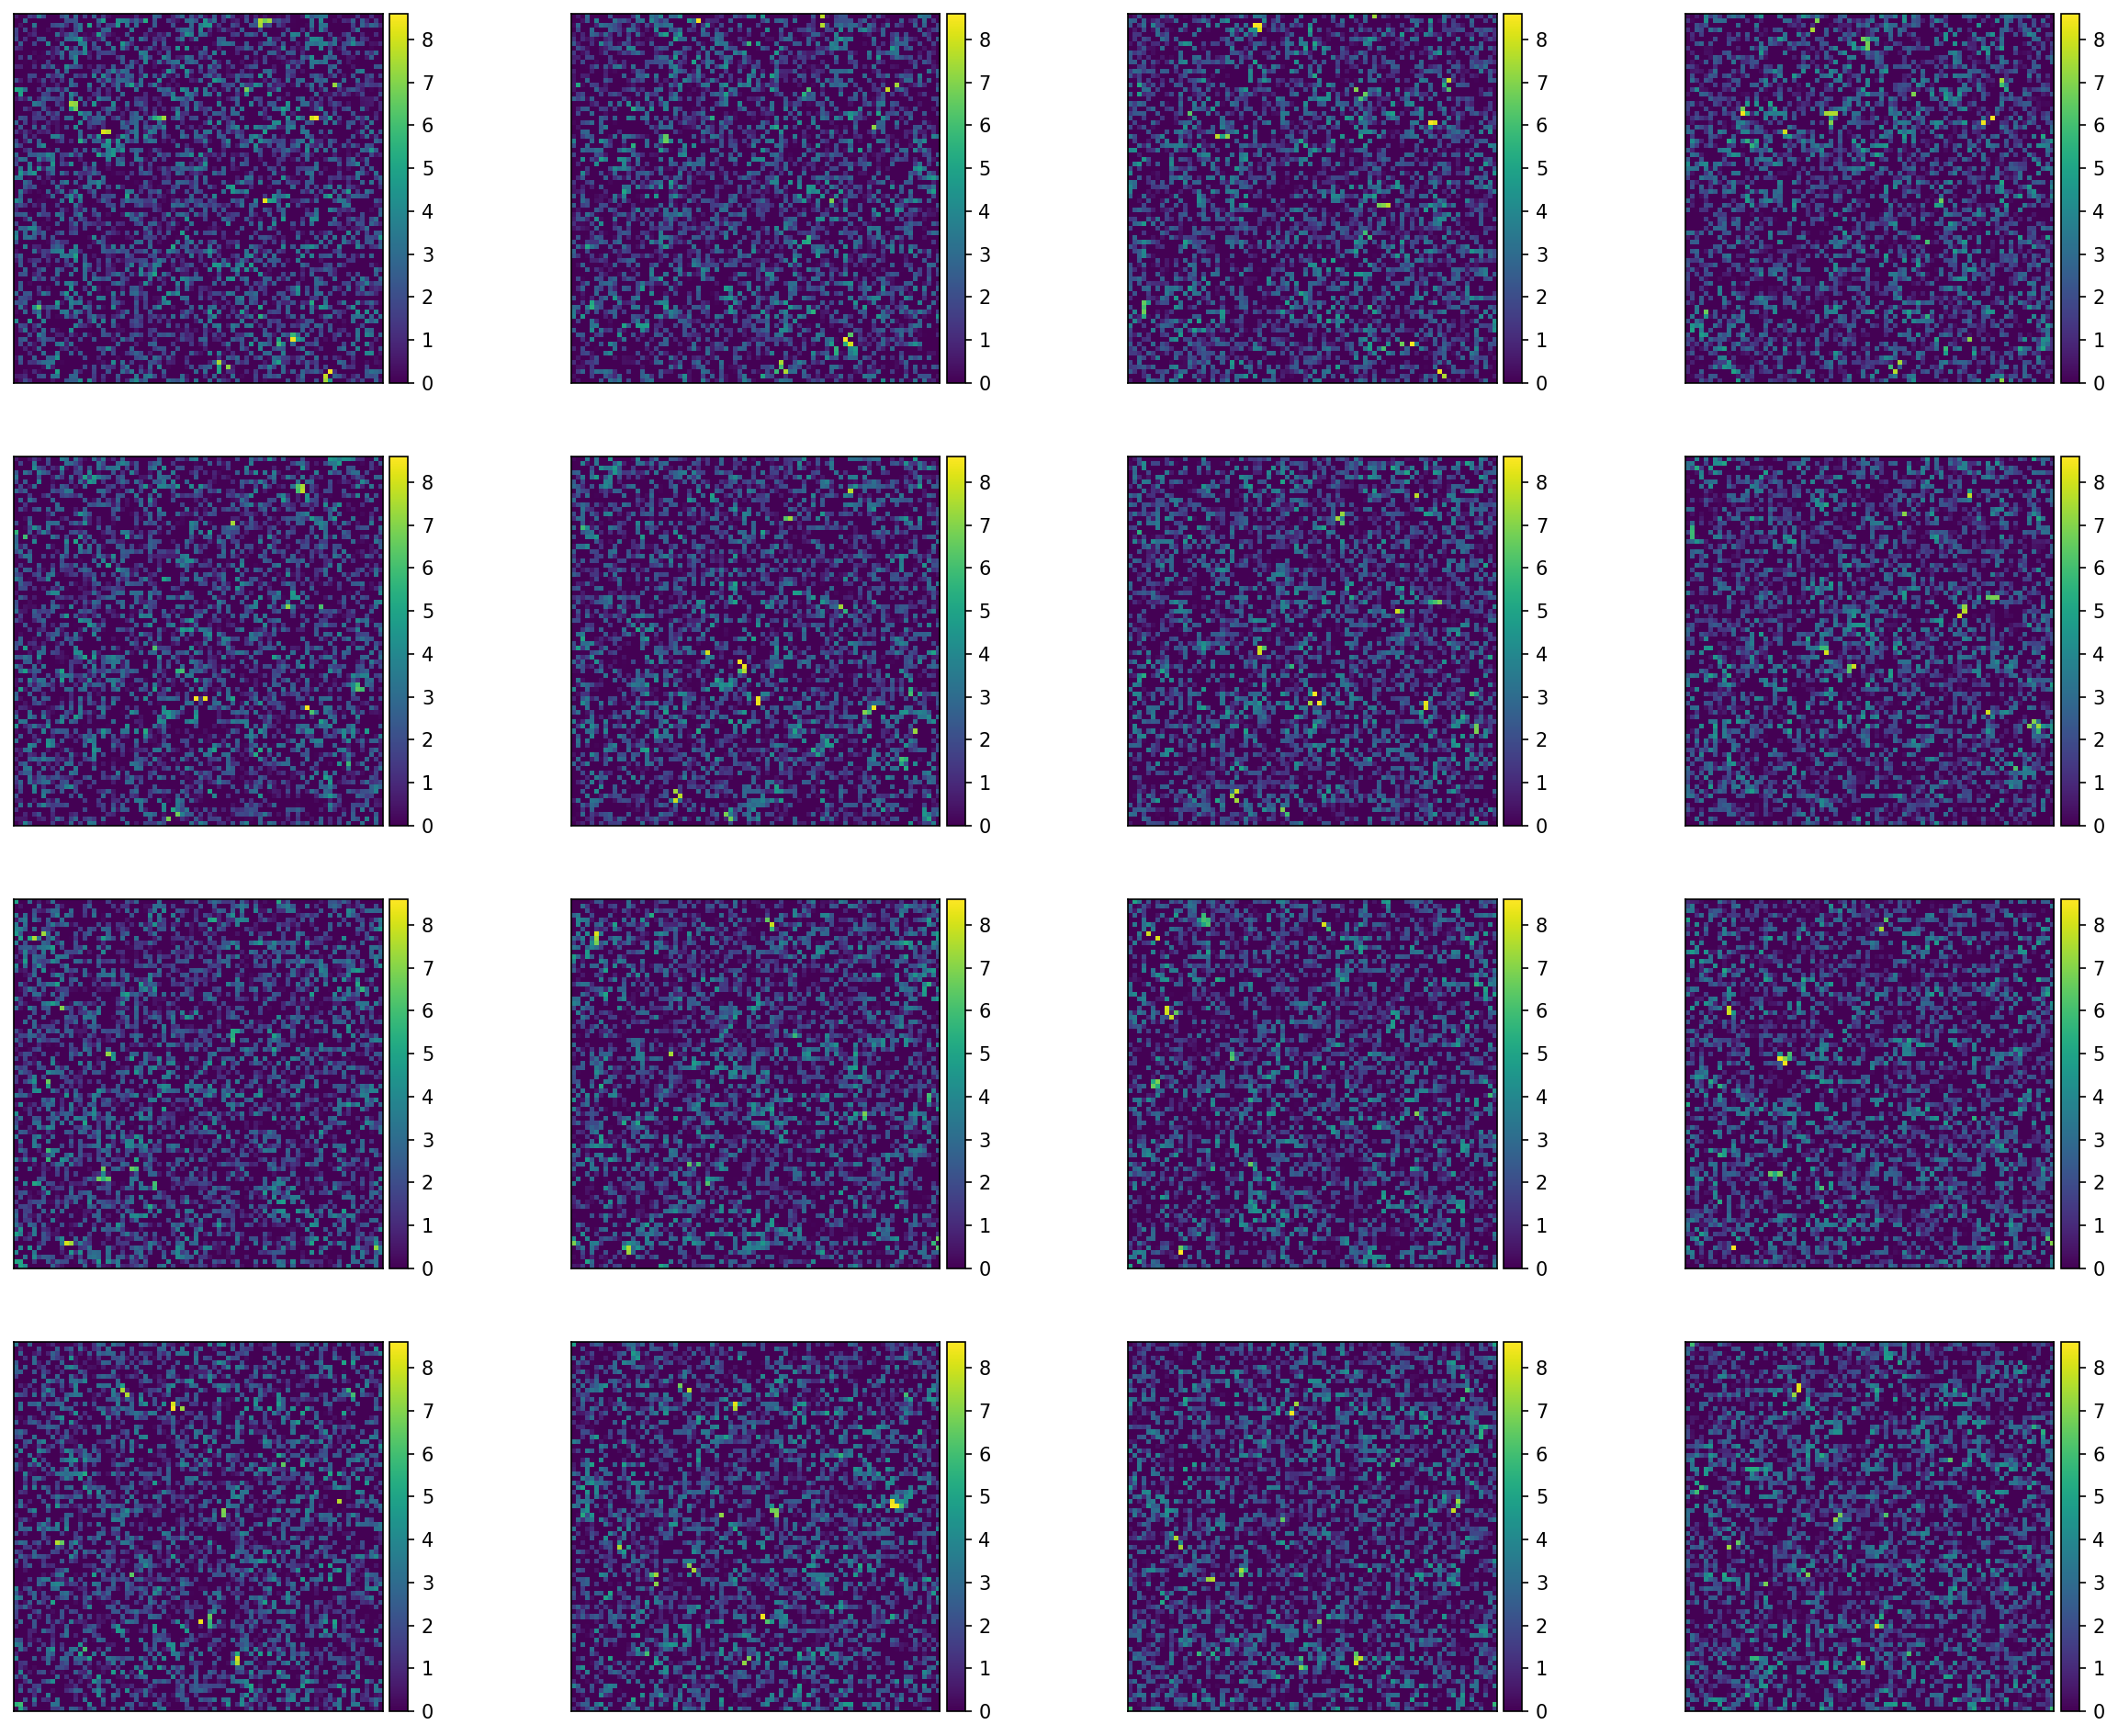

In [187]:
fig,axs = plt.subplots(n_oris,n_phss//2,figsize=(n_phss//2*5,n_oris*4),dpi=150)

for i in range(n_oris):
    for j in range(n_phss//2):
        pf.imshowbar(fig,axs[i,j],inps[i,2*j],origin='lower',cmap='viridis',vmin=0,vmax=np.max(inps))

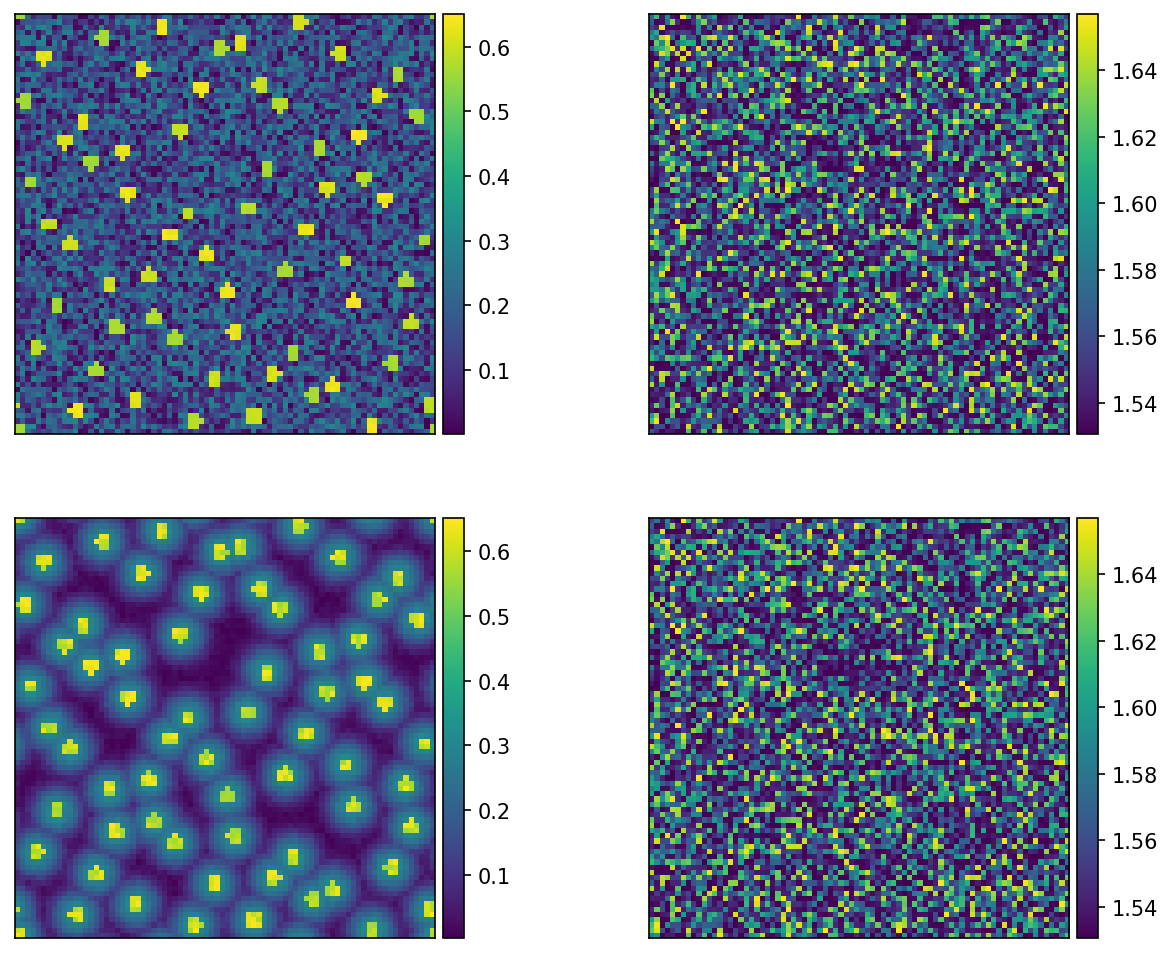

In [188]:
fig,axs = plt.subplots(2,2,figsize=(10,8),dpi=150)

OS,MR = af.calc_OS_MR(inps.transpose(2,3,0,1))
cont_OS,cont_MR = af.calc_OS_MR(cont_inps.transpose(2,3,0,1))

pf.imshowbar(fig,axs[0,0],OS,cmap='viridis',origin='lower')
pf.imshowbar(fig,axs[0,1],MR,cmap='viridis',origin='lower')
pf.imshowbar(fig,axs[1,0],cont_OS,cmap='viridis',origin='lower')
pf.imshowbar(fig,axs[1,1],cont_MR,cmap='viridis',origin='lower')

In [14]:
rec_scale = 0.3

xs,ys = np.meshgrid(np.arange(N4)/N4,np.arange(N4)/N4)
dxs = np.abs(xs[:,:,None,None] - xs[None,None,:,:])
dxs[dxs > 0.5] = 1 - dxs[dxs > 0.5]
dys = np.abs(ys[:,:,None,None] - ys[None,None,:,:])
dys[dys > 0.5] = 1 - dys[dys > 0.5]
ds2s = dxs**2 + dys**2

w = np.exp(-0.5*ds2s/(sig2*rec_scale**2))
w -= np.eye(N4**2).reshape((N4,N4,N4,N4))
w /= np.sum(w,(-2,-1),keepdims=True)

In [204]:
from tqdm import tqdm

rates = np.zeros_like(inps)
cont_rates = np.zeros_like(cont_inps)

start = time.process_time()

for ori_idx in tqdm(range(n_oris)):
    for phs_idx in tqdm(range(n_phss), leave=False):
        rates[ori_idx,phs_idx] = integrate(np.ones(N4**2),inps[ori_idx,phs_idx],
                                           0.25,100,np.array(w.reshape((N4**2,N4**2))),0.5).reshape((N4,N4))
        cont_rates[ori_idx,phs_idx] = integrate(np.ones(N4**2),cont_inps[ori_idx,phs_idx],
                                           0.25,100,np.array(w.reshape((N4**2,N4**2))),0.5).reshape((N4,N4))
    
print('Simulating rate dynamics took',time.process_time() - start,'s')
# np.save('L23_rates_sp_map_k={:.3f}_lker={:.3f}_gam={:.2f}_N4={:d}'.format(
#     k,lker,gam_rec,N4),rates.flatten())

# rates = np.load('L23_rates_sp_map_k={:.3f}_lker={:.3f}_gam={:.2f}_N4={:d}.npy'.format(
#     k,lker,gam_rec,N4)).reshape((n_inp,2,N4,N4))

100%|██████████| 4/4 [02:54<00:00, 43.68s/it]

Simulating rate dynamics took 480.3841259999999 s


0.1525420205252669
0.16179579825725504

0.8839884587780642
0.8814651289939286


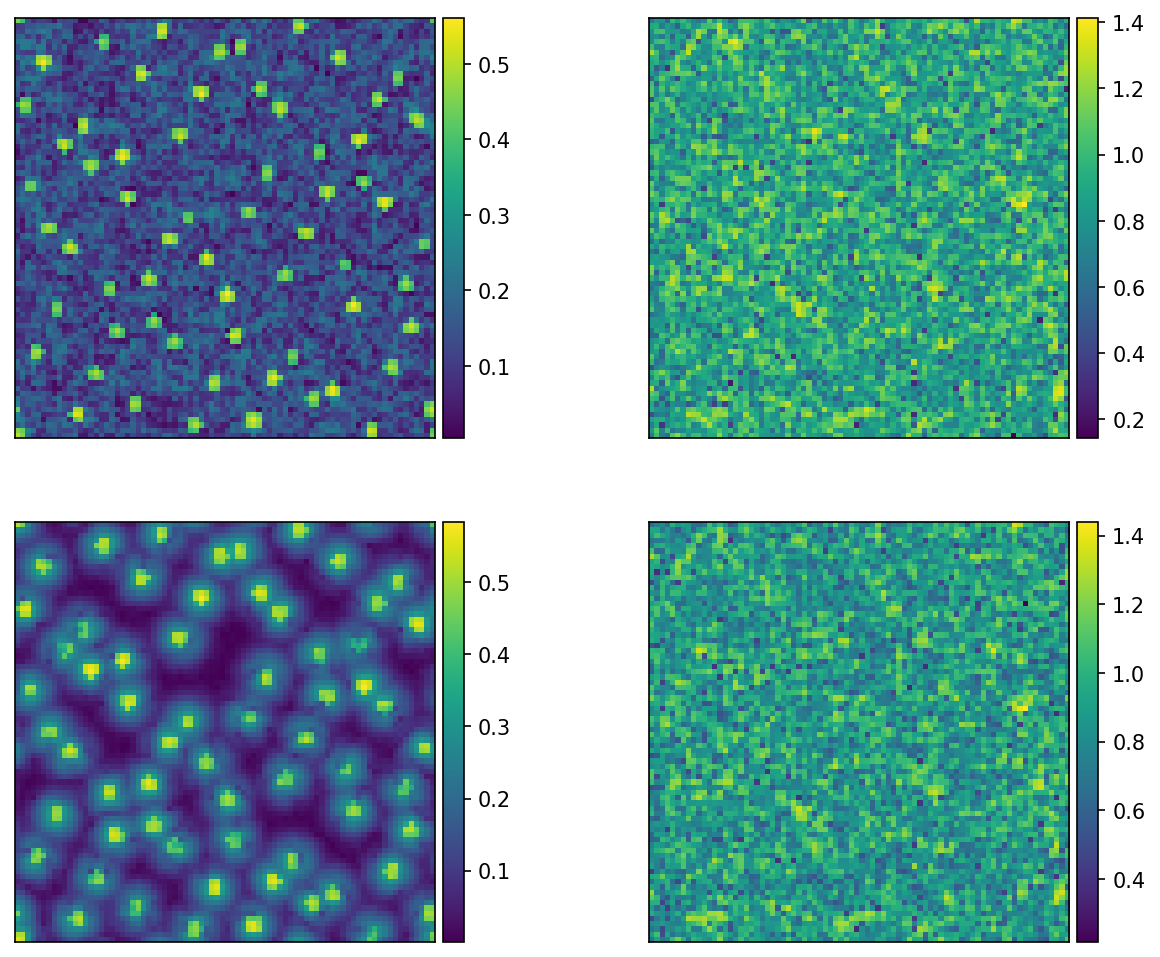

In [205]:
fig,axs = plt.subplots(2,2,figsize=(10,8),dpi=150)

OS,MR = af.calc_OS_MR(rates.transpose(2,3,0,1))
cont_OS,cont_MR = af.calc_OS_MR(cont_rates.transpose(2,3,0,1))

pf.imshowbar(fig,axs[0,0],OS,cmap='viridis',origin='lower')
pf.imshowbar(fig,axs[0,1],MR,cmap='viridis',origin='lower')
pf.imshowbar(fig,axs[1,0],cont_OS,cmap='viridis',origin='lower')
pf.imshowbar(fig,axs[1,1],cont_MR,cmap='viridis',origin='lower')

print(np.mean(OS))
print(np.mean(cont_OS))
print()
print(np.mean(MR))
print(np.mean(cont_MR))

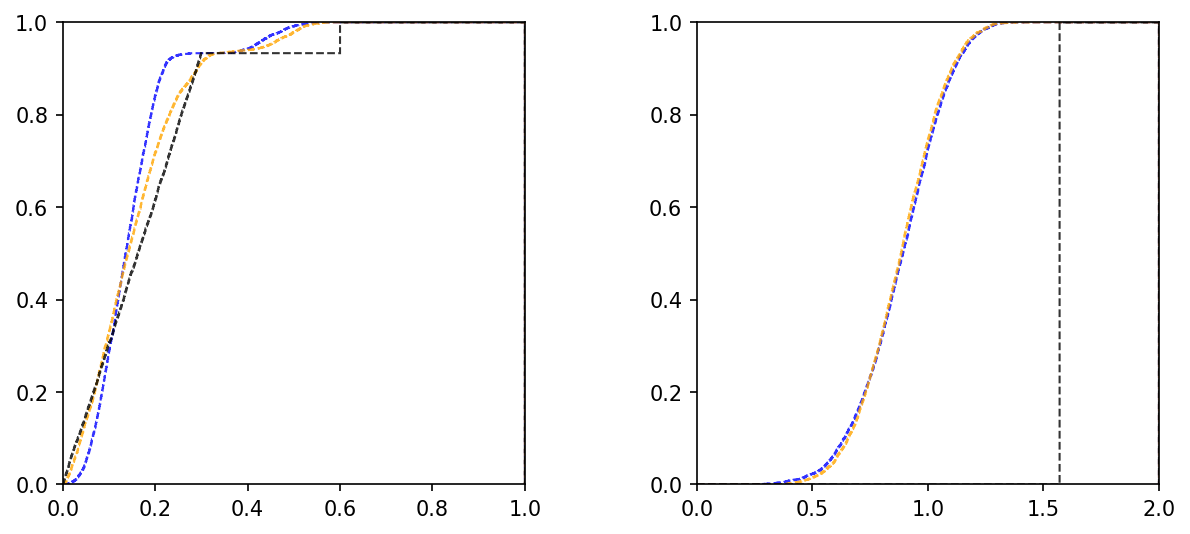

In [206]:
fig,ax = plt.subplots(1,2,figsize=(10,4),dpi=150)

ax[0].hist(np.abs(OS).flatten(), np.linspace(0,1,1001),
    density=True, cumulative=True, label='CDF',
    histtype='step', alpha=0.8, color='b', ls='--')
ax[0].hist(np.abs(cont_OS).flatten(), np.linspace(0,1,1001),
    density=True, cumulative=True, label='CDF',
    histtype='step', alpha=0.8, color='orange', ls='--')
ax[0].hist(np.abs(omap).flatten(), np.linspace(0,1,1001),
    density=True, cumulative=True, label='CDF',
    histtype='step', alpha=0.8, color='k', ls='--')

ax[1].hist(np.abs(MR).flatten(), np.linspace(0,2,1001),
    density=True, cumulative=True, label='CDF',
    histtype='step', alpha=0.8, color='b', ls='--')
ax[1].hist(np.abs(cont_MR).flatten(), np.linspace(0,2,1001),
    density=True, cumulative=True, label='CDF',
    histtype='step', alpha=0.8, color='orange', ls='--')
ax[1].hist([np.pi/2], np.linspace(0,2,1001),
    density=True, cumulative=True, label='CDF',
    histtype='step', alpha=0.8, color='k', ls='--')

ax[0].set_aspect('equal')
ax[1].set_aspect(2)

ax[0].set_xlim(0,1)
ax[0].set_ylim(0,1)
ax[1].set_xlim(0,2)
ax[1].set_ylim(0,1)

fig.savefig('./l4_l23_cdf.pdf')

# Match Maps from L2/3 Model

In [15]:
N4 = 60

dens = 0.01
bgnd_min = 0.00
bgnd_max = 0.3
meanOS = 0.18
maxOS = 0.6

omap = gen_maps(60,dens,bgnd_min,bgnd_max,maxOS,meanOS,0,bgnd_scale=6)
cont_omap = gen_maps(60,dens,bgnd_min,bgnd_max,maxOS,meanOS,0,bgnd_scale=6,cont_oris=True,cont_sels=True)
sig2 = (meanOS - 0.5*(bgnd_min+bgnd_max))/((maxOS - 0.5*(bgnd_min+bgnd_max))*dens*np.pi) / 60**2

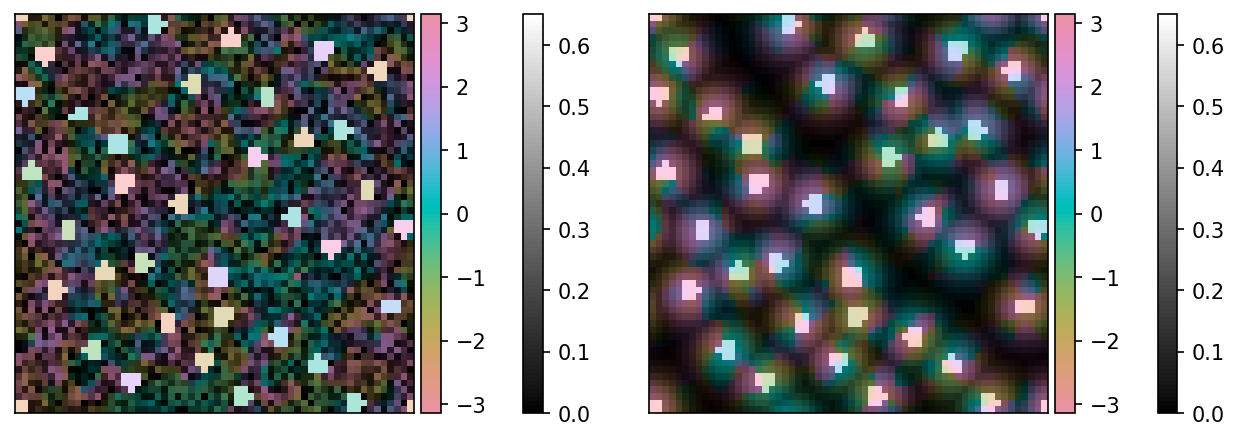

In [8]:
fig,axs = plt.subplots(1,2,figsize=(10,4),dpi=150)
pf.domcolbar(fig,axs[0],omap,rlim=(0,0.65),origin='lower')
pf.domcolbar(fig,axs[1],cont_omap,rlim=(0,0.65),origin='lower')

In [20]:
n_oris = 4
n_phss = 8
n_inp = n_oris*n_phss
inp_oris = np.arange(n_oris)/n_oris * np.pi
inp_phss = np.arange(n_phss)/n_phss * 2*np.pi
inps = np.zeros((n_oris,n_phss,N4,N4))
cont_inps = np.zeros((n_oris,n_phss,N4,N4))

# ring_image = np.fft.fftshift(gen_gaussian_random_field.generate_ring(N4,N4,0,N4/4))

for ori_idx,ori in enumerate(inp_oris):
    abs_phs = gen_abs_phs_map(N4,sctmap,polmap,ori,grate_freq,L_deg)
    for phs_idx,phs in enumerate(inp_phss):
        inps[ori_idx,phs_idx] = elong_inp(ksmap,ori-pos,phs-abs_phs)
        cont_inps[ori_idx,phs_idx] = elong_inp(cont_ksmap,ori-cont_pos,phs-abs_phs)

In [21]:
from tqdm import tqdm

# rates = np.zeros_like(inps)
cont_rates = np.zeros_like(cont_inps)

start = time.process_time()

for ori_idx in tqdm(range(n_oris)):
    for phs_idx in tqdm(range(n_phss), leave=False):
        # rates[ori_idx,phs_idx] = integrate(np.ones(N4**2),inps[ori_idx,phs_idx],
        #                                    0.25,100,np.array(w.reshape((N4**2,N4**2))),0.5).reshape((N4,N4))
        cont_rates[ori_idx,phs_idx] = integrate(np.ones(N4**2),cont_inps[ori_idx,phs_idx],
                                           0.25,100,np.array(w.reshape((N4**2,N4**2))),0.5).reshape((N4,N4))
    
print('Simulating rate dynamics took',time.process_time() - start,'s')
# np.save('L23_rates_sp_map_k={:.3f}_lker={:.3f}_gam={:.2f}_N4={:d}'.format(
#     k,lker,gam_rec,N4),rates.flatten())

# rates = np.load('L23_rates_sp_map_k={:.3f}_lker={:.3f}_gam={:.2f}_N4={:d}.npy'.format(
#     k,lker,gam_rec,N4)).reshape((n_inp,2,N4,N4))

100%|██████████| 4/4 [00:12<00:00,  3.12s/it]

Simulating rate dynamics took 54.962357 s


In [23]:
L4_inp_OPM,L4_inp_MR = af.calc_OPM_MR(cont_inps.transpose(2,3,0,1))
L4_rate_OPM,L4_rate_MR = af.calc_OPM_MR(cont_rates.transpose(2,3,0,1))

In [36]:
with open('./../results/L4_act_L23_sel_dens={:.4f}_grec={:.3f}_thresh={:.2f}/seed=0.pkl'.format(
        0.01,1.15,0.0), 'rb') as handle:
    res_dict = pickle.load(handle)
    
L23_inp_OPM = res_dict['inp_z'][0]
L23_inp_MR = L4_rate_MR
L23_rate_OPM = res_dict['rate_z'][0]

In [72]:
sim_inp_z = res_dict['inp_z']
sim_inp_pref_ori = np.angle(sim_inp_z)*180/(2*np.pi)
sim_inp_pref_ori[sim_inp_pref_ori > 90] -= 180
sim_inp_ori_sel = np.abs(sim_inp_z)
print(np.mean(sim_inp_ori_sel))

sim_rate_z = res_dict['rate_z']
sim_rate_pref_ori = np.angle(sim_rate_z)*180/(2*np.pi)
sim_rate_pref_ori[sim_rate_pref_ori > 90] -= 180
sim_rate_ori_sel = np.abs(sim_rate_z)
print(np.mean(sim_rate_ori_sel[0]))

opm_mismatch = np.abs(sim_inp_pref_ori - sim_rate_pref_ori)[0]
opm_mismatch[opm_mismatch > 90] = 180 - opm_mismatch[opm_mismatch > 90]

0.1426224243372195
0.3777997640209038


In [73]:
L4_fft = np.abs(np.fft.fftshift(np.fft.fft2(L4_rate_OPM - np.nanmean(L4_rate_OPM))))
L4_fps = np.zeros(60//2)

L23_fft = np.abs(np.fft.fftshift(np.fft.fft2(sim_rate_z[0] - np.nanmean(sim_rate_z[0]))))
L23_fps = np.zeros(60//2)

grid = np.arange(-60//2,60//2)
x,y = np.meshgrid(grid,grid)
bin_idxs = np.digitize(np.sqrt(x**2+y**2),np.arange(0,np.ceil(60//2*np.sqrt(2)))+0.5)
for idx in range(60//2):
    L4_fps[idx] = np.mean(L4_fft[bin_idxs == idx])
    L23_fps[idx] = np.mean(L23_fft[bin_idxs == idx])

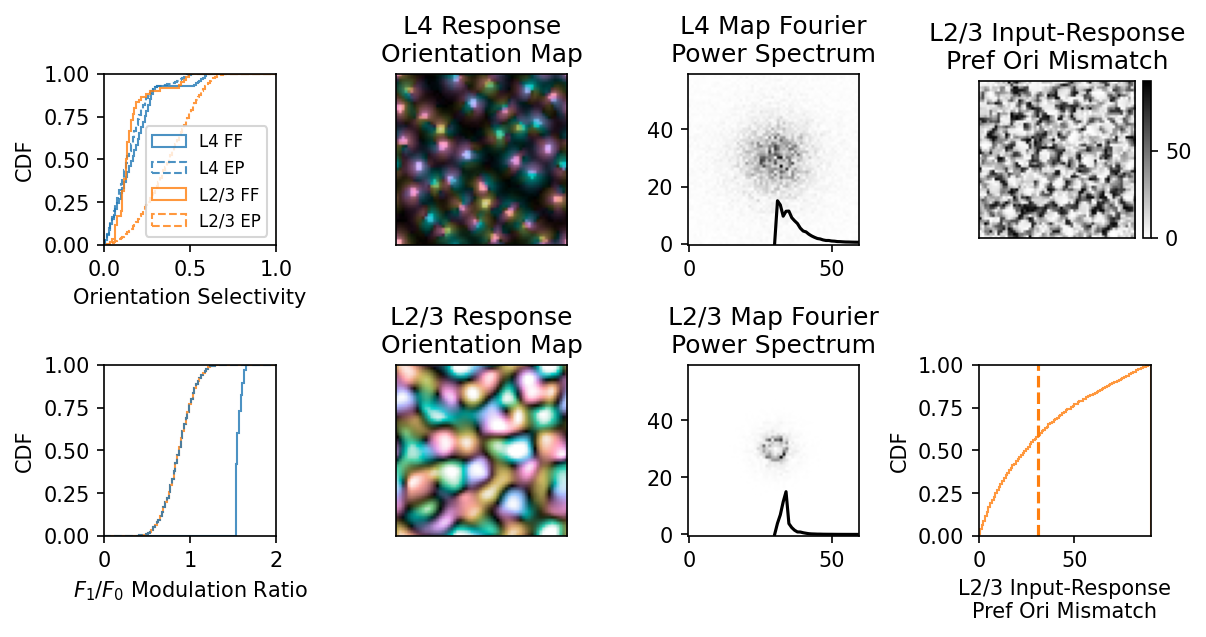

In [79]:
reload(pf)

nbins = 100

fig,axs = plt.subplots(2,4,figsize=(9,4),dpi=150)
fig.subplots_adjust(wspace=0.7,hspace=0.7)

data_max = 1
bins = np.linspace(-data_max/(2*nbins),data_max+data_max/(2*nbins),2+nbins)
axs[0,0].hist(np.abs(L4_inp_OPM).flatten(),bins,
                            density=True,cumulative=True,histtype='step',
                            color='C0',alpha=0.8,label='L4 FF')
axs[0,0].hist(np.abs(L4_rate_OPM).flatten(),bins,
                            density=True,cumulative=True,histtype='step',
                            color='C0',ls='--',alpha=0.8,label='L4 EP')
axs[0,0].hist(np.abs(L23_inp_OPM).flatten(),bins,
                            density=True,cumulative=True,histtype='step',
                            color='C1',alpha=0.8,label='L2/3 FF')
axs[0,0].hist(np.abs(L23_rate_OPM).flatten(),bins,
                            density=True,cumulative=True,histtype='step',
                            color='C1',ls='--',alpha=0.8,label='L2/3 EP')
    
axs[0,0].set_xlim(0,data_max)
axs[0,0].set_ylim(0,1)
axs[0,0].set_xlabel('Orientation Selectivity')
axs[0,0].set_ylabel('CDF')

axs[0,0].legend(fontsize=8)

data_max = 2
bins = np.linspace(-data_max/(2*nbins),data_max+data_max/(2*nbins),2+nbins)
axs[1,0].hist(L4_inp_MR.flatten(),bins,
                            density=True,cumulative=True,histtype='step',
                            color='C0',alpha=0.8,label='L4 FF')
axs[1,0].hist(L23_inp_MR.flatten(),bins,
                            density=True,cumulative=True,histtype='step',
                            color='C1',alpha=0.8,label='L2/3 FF')
axs[1,0].hist(L4_rate_MR.flatten(),bins,
                            density=True,cumulative=True,histtype='step',
                            color='C0',ls='--',alpha=0.8,label='L4 EP')

axs[1,0].set_xlim(0,data_max)
axs[1,0].set_ylim(0,1)
axs[1,0].set_xlabel(r'$F_1/F_0$ Modulation Ratio')
axs[1,0].set_ylabel('CDF')

pf.domcol(fig,axs[0,1],L4_rate_OPM,rlim=(0,0.65),origin='lower')
pf.domcol(fig,axs[1,1],L23_rate_OPM,rlim=(0,0.65),origin='lower')

axs[0,1].set_title('L4 Response\nOrientation Map')
axs[1,1].set_title('L2/3 Response\nOrientation Map')

axs[0,2].imshow(L4_fft,origin='lower',cmap='binary')
axs[0,2].plot(60//2+np.arange(60//2),L4_fps/np.max(L4_fps)*60/4,'k')
axs[1,2].imshow(L23_fft,origin='lower',cmap='binary')
axs[1,2].plot(60//2+np.arange(60//2),L23_fps/np.max(L23_fps)*60/4,'k')

axs[0,2].set_title('L4 Map Fourier\nPower Spectrum')
axs[1,2].set_title('L2/3 Map Fourier\nPower Spectrum')

pf.imshowbar(fig,axs[0,3],opm_mismatch,cmap='binary',origin='lower',vmin=0,vmax=90)

axs[0,3].set_title('L2/3 Input-Response\nPref Ori Mismatch')

data_max = 90
bins = np.linspace(-data_max/(2*nbins),data_max+data_max/(2*nbins),2+nbins)
axs[1,3].hist(opm_mismatch.flatten(),bins,
                            density=True,cumulative=True,histtype='step',
                            color='C1',alpha=0.8)
axs[1,3].axvline(np.mean(opm_mismatch),color='C1',ls='--',label='Mean')
    
axs[1,3].set_xlim(0,data_max)
axs[1,3].set_ylim(0,1)
axs[1,3].set_xlabel('L2/3 Input-Response\nPref Ori Mismatch')
axs[1,3].set_ylabel('CDF')

fig.savefig('./../plots/CosyneFigure_3.pdf',dpi=300)

# Open cluster results

In [77]:
with open('./../results/L4_act_L23_sel_mod_dens={:.4f}_grec={:.3f}/seed=0.pkl'.format(
        0.0141,1.05), 'rb') as handle:
    res_dict = pickle.load(handle)

In [78]:
L4_inp_OPM = res_dict['L4_inp_z']
_,L4_inp_MR = af.calc_OS_MR(cont_inps.transpose(2,3,0,1))#res_dict['L4_inp_mr']
L4_rate_OPM = res_dict['L4_rate_opm']
L4_rate_MR = res_dict['L4_rate_mr']
L23_inp_OPM = res_dict['L4_rate_opm']
L23_inp_MR = res_dict['L4_rate_mr']
L23_rate_OPM = res_dict['L23_rate_opm'][0]
L23_rate_MR = res_dict['L23_rate_mr'][0]

L4_inp_PO = np.angle(L4_inp_OPM)*180/(2*np.pi)
L4_inp_PO[L4_inp_PO > 90] -= 180
L4_rate_PO = np.angle(L4_rate_OPM)*180/(2*np.pi)
L4_rate_PO[L4_rate_PO > 90] -= 180
L23_inp_PO = np.angle(L23_inp_OPM)*180/(2*np.pi)
L23_inp_PO[L23_inp_PO > 90] -= 180
L23_rate_PO = np.angle(L23_rate_OPM)*180/(2*np.pi)
L23_rate_PO[L23_rate_PO > 90] -= 180

L4_mismatch = np.abs(L4_inp_PO - L4_rate_PO)
L4_mismatch[L4_mismatch > 90] = 180 - L4_mismatch[L4_mismatch > 90]
L23_mismatch = np.abs(L23_inp_PO - L23_rate_PO)
L23_mismatch[L23_mismatch > 90] = 180 - L23_mismatch[L23_mismatch > 90]

L4_fft = np.abs(np.fft.fftshift(np.fft.fft2(L4_rate_OPM - np.nanmean(L4_rate_OPM))))
L4_fps = np.zeros(60//2)

L23_fft = np.abs(np.fft.fftshift(np.fft.fft2(L23_rate_OPM - np.nanmean(L23_rate_OPM))))
L23_fps = np.zeros(60//2)

grid = np.arange(-60//2,60//2)
x,y = np.meshgrid(grid,grid)
bin_idxs = np.digitize(np.sqrt(x**2+y**2),np.arange(0,np.ceil(60//2*np.sqrt(2)))+0.5)
for idx in range(60//2):
    L4_fps[idx] = np.mean(L4_fft[bin_idxs == idx])
    L23_fps[idx] = np.mean(L23_fft[bin_idxs == idx])

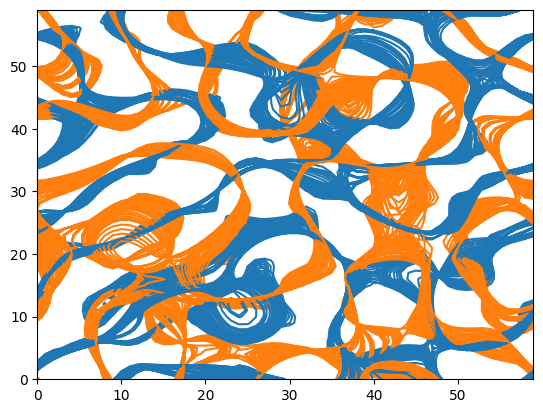

In [80]:
Lam,_ = af.calc_hypercol_size(L23_fps,60)

llams = np.linspace(0.4,1.0,7)*Lam
ulams = np.linspace(1.2,1.8,7)*Lam
npws = np.zeros((len(llams),len(ulams)))

for i,llam in enumerate(llams):
    for j,ulam in enumerate(ulams):
        npws[i,j],_ = af.calc_pinwheels(af.bandpass_filter(L23_rate_OPM,llam,ulam))

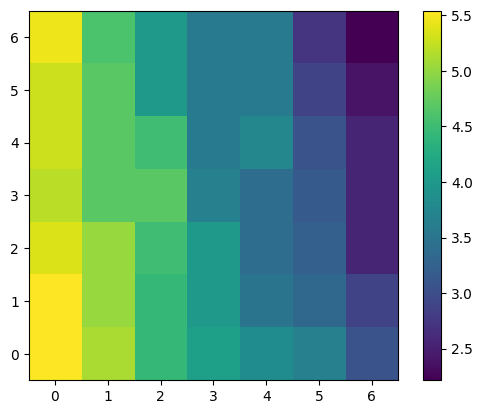

In [81]:
plt.imshow(npws.T*(Lam/60)**2,origin='lower',cmap='viridis')
plt.colorbar()

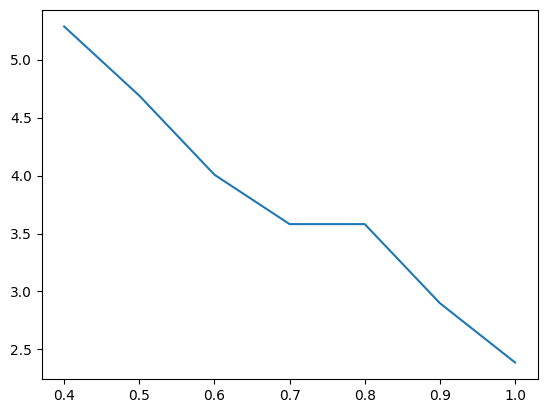

In [82]:
plt.plot(llams/Lam,npws[:,-2]*(Lam/60)**2)

In [83]:
npws[3,-2]*(Lam/60)**2

np.float64(3.5808945891730537)

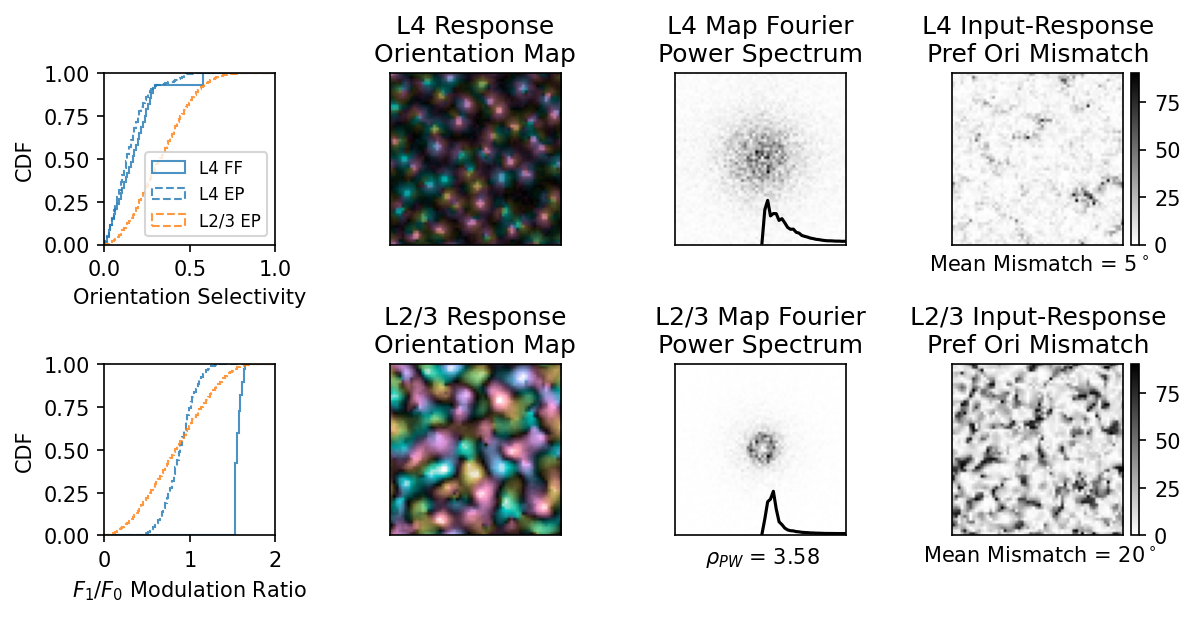

In [86]:
reload(pf)

nbins = 100

fig,axs = plt.subplots(2,4,figsize=(9,4),dpi=150)
fig.subplots_adjust(wspace=0.5,hspace=0.7)

data_max = 1
bins = np.linspace(-data_max/(2*nbins),data_max+data_max/(2*nbins),2+nbins)
axs[0,0].hist(np.abs(L4_inp_OPM).flatten(),bins,
                            density=True,cumulative=True,histtype='step',
                            color='C0',alpha=0.8,label='L4 FF')
axs[0,0].hist(np.abs(L4_rate_OPM).flatten(),bins,
                            density=True,cumulative=True,histtype='step',
                            color='C0',ls='--',alpha=0.8,label='L4 EP')
axs[0,0].hist(np.abs(L23_rate_OPM).flatten(),bins,
                            density=True,cumulative=True,histtype='step',
                            color='C1',ls='--',alpha=0.8,label='L2/3 EP')
    
axs[0,0].set_aspect(1)
axs[0,0].set_xlim(0,data_max)
axs[0,0].set_ylim(0,1)
axs[0,0].set_xlabel('Orientation Selectivity')
axs[0,0].set_ylabel('CDF')

axs[0,0].legend(fontsize=8)

data_max = 2
bins = np.linspace(-data_max/(2*nbins),data_max+data_max/(2*nbins),2+nbins)
axs[1,0].hist(L4_inp_MR.flatten(),bins,
                            density=True,cumulative=True,histtype='step',
                            color='C0',alpha=0.8,label='L4 FF')
axs[1,0].hist(L4_rate_MR.flatten(),bins,
                            density=True,cumulative=True,histtype='step',
                            color='C0',ls='--',alpha=0.8,label='L4 EP')
axs[1,0].hist(L23_rate_MR.flatten(),bins,
                            density=True,cumulative=True,histtype='step',
                            color='C1',ls='--',alpha=0.8,label='L4 EP')

axs[1,0].set_aspect(2)
axs[1,0].set_xlim(0,data_max)
axs[1,0].set_ylim(0,1)
axs[1,0].set_xlabel(r'$F_1/F_0$ Modulation Ratio')
axs[1,0].set_ylabel('CDF')

pf.domcol(fig,axs[0,1],L4_rate_OPM,rlim=(0,0.8),origin='lower')
pf.domcol(fig,axs[1,1],L23_rate_OPM,rlim=(0,0.8),origin='lower')

axs[0,1].set_title('L4 Response\nOrientation Map')
axs[1,1].set_title('L2/3 Response\nOrientation Map')

axs[0,2].imshow(L4_fft,origin='lower',cmap='binary')
axs[0,2].plot(60//2+np.arange(60//2),L4_fps/np.max(L4_fps)*60/4,'k')
axs[0,2].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
axs[1,2].imshow(L23_fft,origin='lower',cmap='binary')
axs[1,2].plot(60//2+np.arange(60//2),L23_fps/np.max(L23_fps)*60/4,'k')
axs[1,2].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
axs[1,2].text(N4//2,-N4//15,r'$\rho_{PW}$'+' = {:.2f}'.format(3.58),
              ha='center',va='top')

axs[0,2].set_title('L4 Map Fourier\nPower Spectrum')
axs[1,2].set_title('L2/3 Map Fourier\nPower Spectrum')

pf.imshowbar(fig,axs[0,3],L4_mismatch,cmap='binary',origin='lower',vmin=0,vmax=90)
axs[0,3].text(N4//2,-N4//15,'Mean Mismatch = {:d}'.format(np.mean(L4_mismatch).astype(int))+r'${}^\circ$',
              ha='center',va='top')
pf.imshowbar(fig,axs[1,3],L23_mismatch,cmap='binary',origin='lower',vmin=0,vmax=90)
axs[1,3].text(N4//2,-N4//15,'Mean Mismatch = {:d}'.format(np.mean(L23_mismatch).astype(int))+r'${}^\circ$',
              ha='center',va='top')

axs[0,3].set_title('L4 Input-Response\nPref Ori Mismatch')
axs[1,3].set_title('L2/3 Input-Response\nPref Ori Mismatch')

# data_max = 90
# bins = np.linspace(-data_max/(2*nbins),data_max+data_max/(2*nbins),2+nbins)
# axs[1,3].hist(L23_mismatch.flatten(),bins,
#                             density=True,cumulative=True,histtype='step',
#                             color='C1',alpha=0.8)
# axs[1,3].axvline(np.mean(L23_mismatch),color='C1',ls='--',label='Mean')
    
# axs[1,3].set_xlim(0,data_max)
# axs[1,3].set_ylim(0,1)
# axs[1,3].set_xlabel('L2/3 Input-Response\nPref Ori Mismatch')
# axs[1,3].set_ylabel('CDF')

fig.savefig('./../plots/CosyneFigure_3.pdf',dpi=300)